In [13]:
# coding: utf-8
import sys
import numpy
import sklearn
from time import time
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from scipy.sparse import hstack
from scipy.sparse import coo_matrix, bmat
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer,CountVectorizer,TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline   
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV 
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from pprint import pprint

In [14]:
olderr = np.seterr(all='ignore')

In [15]:

def input_data(train_file,divide_number,end_number,tags):
    train_words = []
    train_tags=[]
    test_words = []
    test_tags=[]
    with open(train_file, 'r',encoding='gb18030') as f:
        text=f.readlines()
        train_data=text[:divide_number]   
        for single_query in train_data:
            single_query_list = single_query.split(' ')
            single_query_list.pop(0)#id
            if(single_query_list[tags]!='0'):
                train_tags.append(single_query_list[tags])
                single_query_list.pop(0)
                single_query_list.pop(0)
                single_query_list.pop(0)
                train_words.append((str(single_query_list)).replace(',',' ').replace('\'','').lstrip('[').rstrip(']').replace('\\n',''))
        test_data=text[divide_number:end_number]   
        for single_query in test_data:
            single_query_list = single_query.split(' ')
            single_query_list.pop(0)#id
            if(single_query_list[tags]!='0'):
                test_tags.append(single_query_list[tags])
                single_query_list.pop(0)
                single_query_list.pop(0)
                single_query_list.pop(0)
                test_words.append((str(single_query_list)).replace(',',' ').replace('\'','').lstrip('[').rstrip(']').replace('\\n',''))
       # print(test_words)
        #print(test_tags_age)
    print('input_data done!')
    return train_words, train_tags, test_words, test_tags

In [16]:
def feature_selection_chi2(train_data,train_tags,test_data,n_dimensionality):

    print('feature_selection_chi2'+'\n'+'n_dimensionality:%d' %n_dimensionality)
    ch2= SelectKBest(score_func=chi2, k=n_dimensionality)
    train_data=ch2.fit_transform(train_data,train_tags)
    test_data=ch2.transform(test_data)
    return train_data  , test_data 

In [17]:
def tfidf_vectorize_1(train_words,test_words):
    print ('*************************\nTfidfVectorizer\n*************************')   
    tv = TfidfVectorizer(sublinear_tf = True)
                                          
    tfidf_train_2 = tv.fit_transform(train_words);  #得到矩阵
    tv2 = TfidfVectorizer(vocabulary = tv.vocabulary_);  
    tfidf_test_2 = tv2.fit_transform(test_words);  
    print ("the shape of train is "+repr(tfidf_train_2.shape))  
    print ("the shape of test is "+repr(tfidf_test_2.shape))
    return  tfidf_train_2 ,tfidf_test_2

In [18]:
def tfidf_vectorize(train_words,train_tags,test_words,test_tags,n_dimensionality):
    print ('*************************TfidfVectorizer+chi2*************************')   
    t0=time()
    tv = TfidfVectorizer(sublinear_tf = True) # 
                                          
    tfidf_train_2 = tv.fit_transform(train_words);  #得到矩阵
    tv2 = TfidfVectorizer(vocabulary = tv.vocabulary_);  
    tfidf_test_2 = tv2.fit_transform(test_words);  
    print ("the shape of train is "+repr(tfidf_train_2.shape))  
    print ("the shape of test is "+repr(tfidf_test_2.shape))
    train_data,test_data=feature_selection_chi2(tfidf_train_2,train_tags,tfidf_test_2,n_dimensionality) 
    print("done in %0.3fs." % (time() - t0))
    return  train_data,test_data

In [19]:
def SVM_single(train_data,test_data,train_tags): 
#SVM Classifier  
    from sklearn.svm import SVC  
    print ('******************************SVM*****************************' )
    t0=time()
    svclf = SVC(kernel = 'linear')
    svclf.fit(train_data,train_tags)  
    pred_tags = svclf.predict(test_data) 
    print("done in %0.3fs." % (time() - t0))
    return pred_tags

In [20]:
def evaluate_single(test_tags, test_tags_pre):
    actual=test_tags
    pred=test_tags_pre
    print ('accuracy_score:{0:.3f}'.format(accuracy_score(actual, pred)))
    print('confusion_matrix:')
    cm = confusion_matrix(actual, pred)
    print(confusion_matrix(actual, pred))
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Assuming you have the confusion matrix stored in the variable 'confusion_matrix'
    # You can replace it with the actual variable name in your code

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

In [21]:
def test_single(tags,n_dimensionality,n_topics):
    train_file = 'train_data_fenci.txt'
    devide_number=16000
    end_number=19000
    n_feature=320000
    print('file:'+train_file)
    print('tags:%d   ' %tags )
    #将数据分为训练与测试，获取训练与测试数据的标签
    train_words, train_tags,test_words, test_tags = input_data(train_file,devide_number,end_number,tags)
    # tf-idf特征提取并vetorize
    train_data,test_data= tfidf_vectorize_1(train_words,test_words)
    # tf-idf特征提取+卡方并vetorize
    # train_data,test_data= tfidf_vectorize(train_words,train_tags,test_words,test_tags,n_dimensionality)

    test_tags_pre=SVM_single(train_data,test_data,train_tags)

    #计算正确率
    evaluate_single(numpy.asarray(test_tags), test_tags_pre)

file:train_data_fenci.txt
tags:0   
input_data done!
*************************
TfidfVectorizer
*************************
the shape of train is (16000, 333511)
the shape of test is (1663, 333511)
******************************SVM*****************************
done in 744.539s.
clf done!
accuracy_score:0.580
confusion_matrix:
[[548 109  38  18   0   0]
 [130 228  66   4   0   0]
 [ 55  81 156  25   0   0]
 [ 38  27  71  33   0   0]
 [  8   4  11  11   0   0]
 [  0   0   2   0   0   0]]


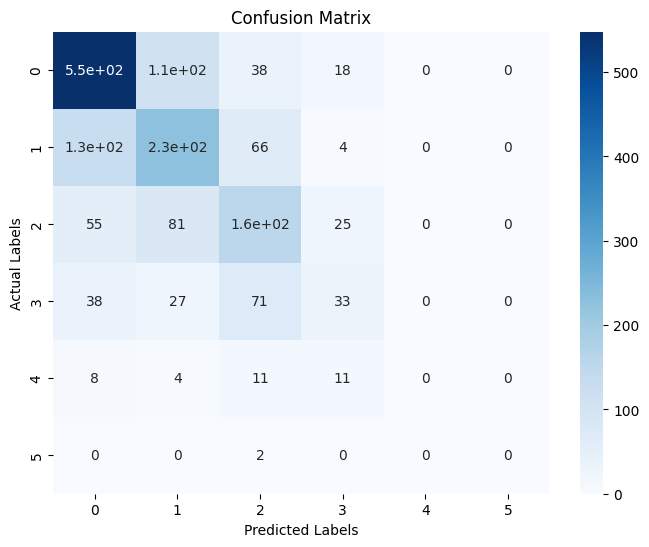

In [22]:
# age
test_single(0,59500,100)

file:train_data_fenci.txt
tags:1   
input_data done!
*************************
TfidfVectorizer
*************************
the shape of train is (16000, 333511)
the shape of test is (1663, 333511)
******************************SVM*****************************
done in 844.080s.
clf done!
accuracy_score:0.824
confusion_matrix:
[[847 122]
 [170 524]]


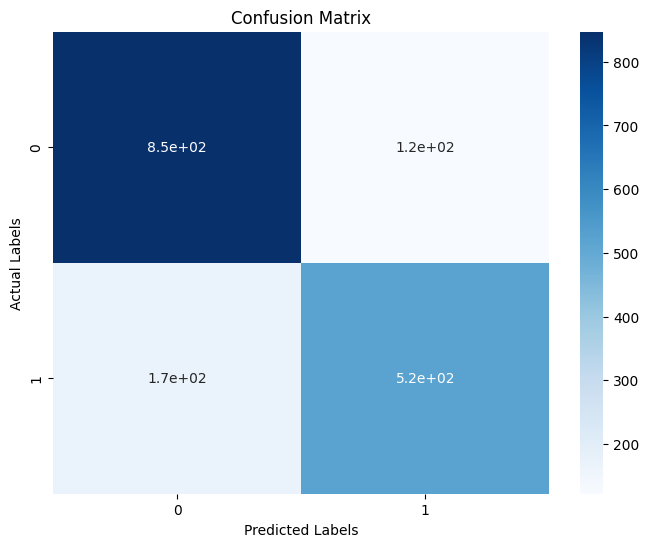

In [23]:
# gender
test_single(1,12000,5)

file:train_data_fenci.txt
tags:2   
input_data done!
*************************
TfidfVectorizer
*************************
the shape of train is (16000, 333511)
the shape of test is (1663, 333511)
******************************SVM*****************************
done in 850.166s.
clf done!
accuracy_score:0.591
confusion_matrix:
[[  0   0   4   3   0   0]
 [  0   0   6   5   2   0]
 [  0   0 167 109  55   4]
 [  0   0 107 253 161   2]
 [  0   0  33 101 558   2]
 [  0   0  13  17  56   5]]


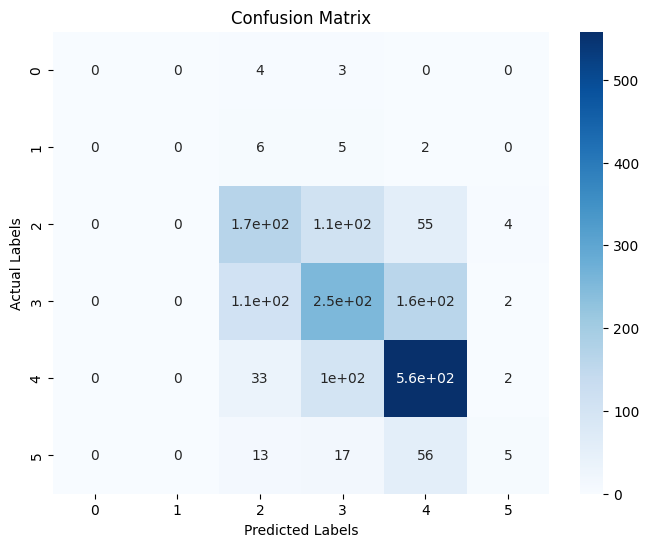

In [24]:
# education
test_single(2,130,10)